In [1]:
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.observer import Observer
from deorbit.utils.constants import EARTH_RADIUS


In [2]:
save_path = "eg/EKF_example_3D/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

np.random.seed(0)
if sim_data is None or sim_config is None:
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 5, 5, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


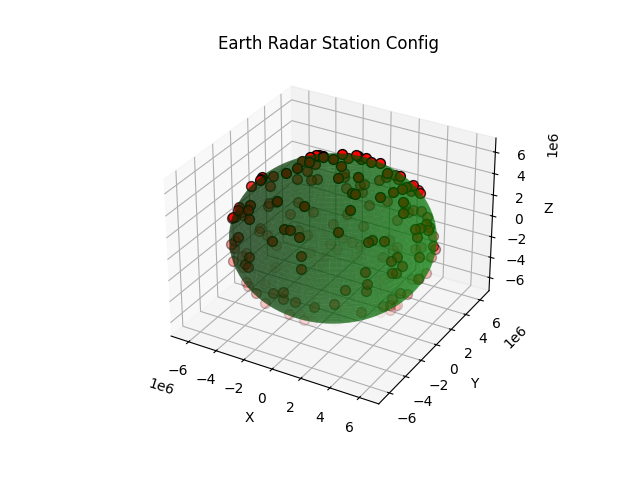

In [12]:
#initialising observer class with sim data
np.random.seed(1)
obs = Observer(number_of_radars=200, dim=3)

sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=10)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)
#dim = sim_data.state_array().shape[1]

obs.plot_config()


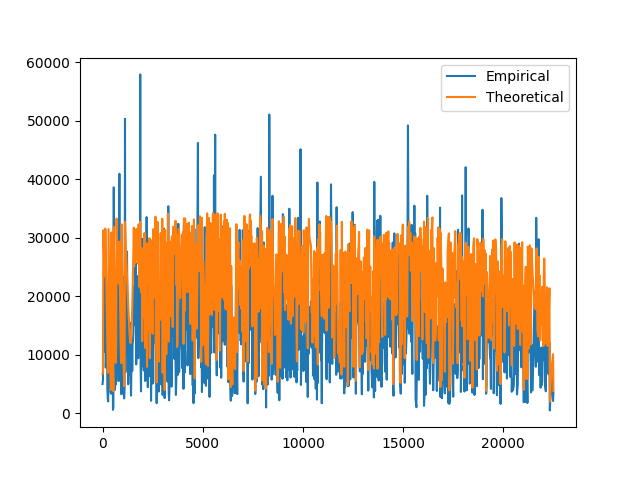

In [13]:
fig, ax = plt.subplots()

sim_times_observed = np.array([i for i, t in enumerate(sim_times) if t in observation_times])
observation_error = np.linalg.norm(observation_states - sim_states[sim_times_observed], axis=1)
ax.plot(observation_times, observation_error, label="Empirical")
ax.plot(observation_times, np.sqrt(observed_covariances[:,0,0])*np.sqrt(6), label="Theoretical")
ax.legend()
plt.show()

In [14]:


# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])#process noise
P = np.eye(sim_data.state_array().shape[1]) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.eye(sim_data.state_array().shape[1])

dt = sim_config.simulation_method_kwargs.time_step

#initialising 3D EKF
ekf = EKF(dim=3)

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

100%|██████████| 1032/1032 [00:06<00:00, 170.25it/s]


In [15]:
print(len(estimated_traj))


11363


11363


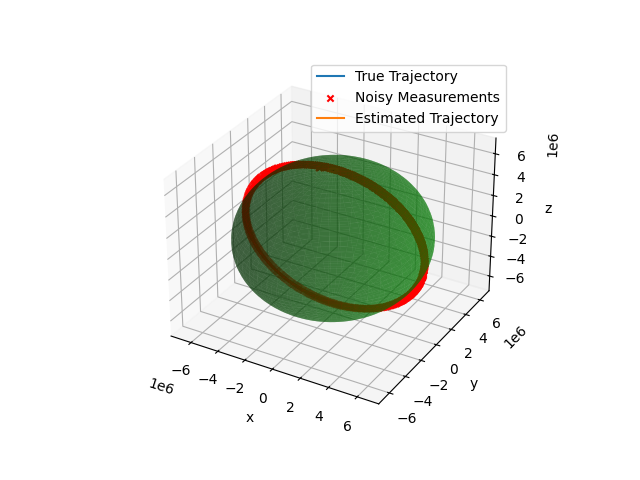

In [16]:
%matplotlib widget
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")

#plotting EARTH
r = EARTH_RADIUS

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

ax.plot_surface(x, y, z, color="g", alpha=0.5)
print(len(estimated_traj))
splice = slice(len(estimated_traj))

#plotting simulated 'true' trajectory
true_traj = sim_data.state_array()[:, :3]
ax.plot(true_traj[:, 0], true_traj[:, 1], true_traj[:, 2], label='True Trajectory')

#plotting observations
ax.scatter(observation_states[:, 0], observation_states[:, 1], observation_states[:, 2], marker='x', color='r', label='Noisy Measurements', s=20)

#plotting prediction
ax.plot(estimated_traj[:, 0][splice], estimated_traj[:, 1][splice], estimated_traj[:, 2][splice], label = 'Estimated Trajectory')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()

plt.show()


In [ ]:
print(sim_data.state_array()[splice][-10:])

[[-5.37832139e+05  4.43474241e+03  6.50281467e+06 -7.78848484e+03
  -2.13468823e+00 -6.43088816e+02]
 [-5.53407508e+05  4.43048858e+03  6.50150988e+06 -7.78690039e+03
  -2.13766802e+00 -6.61736774e+02]
 [-5.68979653e+05  4.42625476e+03  6.50016779e+06 -7.78526642e+03
  -2.09272574e+00 -6.80354095e+02]
 [-5.84548535e+05  4.42199616e+03  6.49878843e+06 -7.78362160e+03
  -2.15687094e+00 -6.99003721e+02]
 [-6.00114132e+05  4.41765138e+03  6.49737182e+06 -7.78193061e+03
  -2.18723945e+00 -7.17609521e+02]
 [-6.15676204e+05  4.41318890e+03  6.49591794e+06 -7.78014935e+03
  -2.25019626e+00 -7.36258890e+02]
 [-6.31234693e+05  4.40871613e+03  6.49442673e+06 -7.77830691e+03
  -2.22531720e+00 -7.54946830e+02]
 [-6.46789544e+05  4.40423712e+03  6.49289815e+06 -7.77654865e+03
  -2.25599417e+00 -7.73623458e+02]
 [-6.62340709e+05  4.39972685e+03  6.49133217e+06 -7.77462650e+03
  -2.26805946e+00 -7.92360609e+02]
 [-6.77888046e+05  4.39515890e+03  6.48972884e+06 -7.77270512e+03
  -2.31365541e+00 -8.1100